In [11]:
import pandas as pd
import os

In [12]:
# Define file paths
data_dir = "./data"
file_stemmed = os.path.join(data_dir, "survey_clean_stemmed_sentiment.csv")
file_clean = os.path.join(data_dir, "survey_clean_sentiment.csv")
file_output = os.path.join(data_dir, "sentiment.csv")

# Check if the files exist
if not os.path.exists(file_stemmed):
    print(f"File not found: {file_stemmed}")
elif not os.path.exists(file_clean):
    print(f"File not found: {file_clean}")
else:
    print("Files found. You can proceed.")

Files found. You can proceed.


In [13]:
try:
    # Read in the data
    sentiment_stemmed = pd.read_csv(file_stemmed)
    sentiment_clean = pd.read_csv(file_clean)

    # Select only the columns we need
    sentiment_stemmed = sentiment_stemmed[
        ["stemmed_message", "sentiment_score", "sentiment"]
    ]
    sentiment_clean = sentiment_clean[
        ["processed_message", "sentiment_score", "sentiment"]
    ]

    # Rename the columns for clarity
    sentiment_stemmed.rename(
        columns={
            "stemmed_message": "text_stemmed",
            "sentiment_score": "sentiment_score_stemmed",
            "sentiment": "sentiment_stemmed",
        },
        inplace=True,
    )
    sentiment_clean.rename(
        columns={
            "processed_message": "text_clean",
            "sentiment_score": "sentiment_score_clean",
            "sentiment": "sentiment_clean",
        },
        inplace=True,
    )

    # Merge the two dataframes based on the index
    sentiment = pd.merge(
        sentiment_stemmed, sentiment_clean, left_index=True, right_index=True
    )

    # Encode the columns of sentiment as numbers for easier analysis
    sentiment["sentiment_stemmed"] = sentiment["sentiment_stemmed"].map(
        {"positive": 1, "neutral": 0, "negative": -1}
    )
    sentiment["sentiment_clean"] = sentiment["sentiment_clean"].map(
        {"positive": 1, "neutral": 0, "negative": -1}
    )


    # Save the new dataframe to a new file
    sentiment.to_csv(file_output, index=False)
    print("File saved successfully.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

File saved successfully.


Unique labels in y_true: [-1  1  0]
Unique labels in y_pred: [-1  0  1]


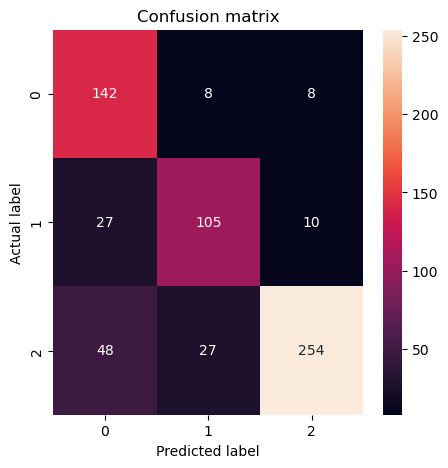

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate


def check_columns(df, columns):
    """Check if the necessary columns exist in the DataFrame."""
    return all(column in df.columns for column in columns)


def check_labels(y_true, y_pred, label_mapping):
    """Check if the labels in y_true and y_pred are in the label_mapping."""
    return set(y_true.unique()).issubset(label_mapping.keys()) and set(
        y_pred.unique()
    ).issubset(label_mapping.keys())


def plot_confusion_matrix(y_true_decoded, y_pred_decoded):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true_decoded, y_pred_decoded)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()


y_true = sentiment["sentiment_clean"]
y_pred = sentiment["sentiment_stemmed"]

# Check if the necessary columns exist in the sentiment DataFrame
if not check_columns(sentiment, ["sentiment_clean", "sentiment_stemmed"]):
    print("Necessary columns not found in the sentiment DataFrame.")
else:
    print("Unique labels in y_true:", y_true.unique())
    print("Unique labels in y_pred:", y_pred.unique())
    y_true = sentiment["sentiment_clean"]
    y_pred = sentiment["sentiment_stemmed"]
    label_mapping = {-1: "negative", 0: "neutral", 1: "positive"}

    # Check if the labels in y_true and y_pred are in the label_mapping
    if not check_labels(y_true, y_pred, label_mapping):
        print("Unexpected labels found in y_true or y_pred.")
    else:
        y_true_decoded = y_true.replace(label_mapping)
        y_pred_decoded = y_pred.replace(label_mapping)
        plot_confusion_matrix(y_true_decoded, y_pred_decoded)

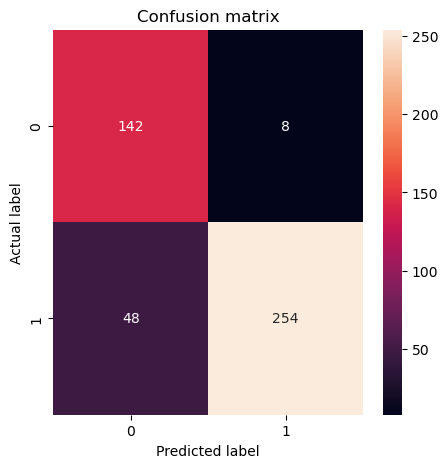

+---+-----------+-------+
|   |  Metric   | Score |
+---+-----------+-------+
| 0 | Accuracy  | 87.6% |
| 1 | Precision | 96.9% |
| 2 |  Recall   | 84.1% |
| 3 | F1 score  | 90.1% |
| 4 |    MCC    | 75.1% |
+---+-----------+-------+


In [15]:
# Create another confusion matrix for the sentiment
# The confusion matrix consist of the following:
# True Positive (TP): The model correctly predicts the positive class
# True Negative (TN): The model correctly predicts the negative class
# False Positive (FP): The model incorrectly predicts the positive class
# False Negative (FN): The model incorrectly predicts the negative class
# The confusion matrix is a 2x2 matrix that looks like this:
#                Predicted Negative  Predicted Positive
# Actual Negative        TN                  FP
# Actual Positive        FN                  TP

# Calculate the number of True Positives
TP = sum((y_true == 1) & (y_pred == 1))

# Calculate the number of True Negatives
TN = sum((y_true == -1) & (y_pred == -1))

# Calculate the number of False Positives
FP = sum((y_true == -1) & (y_pred == 1))

# Calculate the number of False Negatives
FN = sum((y_true == 1) & (y_pred == -1))

# Plot the 2x2 matrix
plt.figure(figsize=(5, 5))
sns.heatmap([[TN, FP], [FN, TP]], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

# Calculate the accuracy, precision, recall, F1 score, and MCC
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
mcc = (TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5


# Tabulate the results
results = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 score", "MCC"],
        "Score": [
            "{:.1f}%".format(metric * 100)
            for metric in [accuracy, precision, recall, f1, mcc]
        ],
    }
)

# Print the DataFrame in a nice table format
print(tabulate(results, headers="keys", tablefmt="pretty"))

In [16]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
import pandas as pd
from tabulate import tabulate

# Make error rate calculations for the confusion matrix
cm = confusion_matrix(y_true_decoded, y_pred_decoded)
error_rate = 1 - cm.diagonal().sum() / cm.sum()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average=None)

# Create a DataFrame with the metrics
metrics = pd.DataFrame(
    {
        "Error Rate": ["{:.1f}%".format(error_rate * 100)],
        "Accuracy": ["{:.1f}%".format(accuracy * 100)],
        "Precision": [
            "{:.1f}%".format(precision.mean() * 100)
        ],  # Use the mean precision if there are multiple classes
    }
)

# Print the DataFrame in a nice table format
print(tabulate(metrics, headers="keys", tablefmt="pretty"))

# Generate the classification report
report = classification_report(
    y_true, y_pred, target_names=label_mapping.values(), output_dict=True
)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Convert the scores to percentages with one decimal place
report_df["precision"] = ["{:.1f}%".format(val * 100) for val in report_df["precision"]]
report_df["recall"] = ["{:.1f}%".format(val * 100) for val in report_df["recall"]]
report_df["f1-score"] = ["{:.1f}%".format(val * 100) for val in report_df["f1-score"]]

# Print the DataFrame in a nice table format
print("\nClassification Report:\n")
print(tabulate(report_df, headers="keys", tablefmt="pretty"))

+---+------------+----------+-----------+
|   | Error Rate | Accuracy | Precision |
+---+------------+----------+-----------+
| 0 |   20.3%    |  79.7%   |   77.9%   |
+---+------------+----------+-----------+

Classification Report:

+--------------+-----------+--------+----------+--------------------+
|              | precision | recall | f1-score |      support       |
+--------------+-----------+--------+----------+--------------------+
|   negative   |   65.4%   | 89.9%  |  75.7%   |       158.0        |
|   neutral    |   75.0%   | 73.9%  |  74.5%   |       142.0        |
|   positive   |   93.4%   | 77.2%  |  84.5%   |       329.0        |
|   accuracy   |   79.7%   | 79.7%  |  79.7%   | 0.7965023847376789 |
|  macro avg   |   77.9%   | 80.3%  |  78.2%   |       629.0        |
| weighted avg |   82.2%   | 79.7%  |  80.0%   |       629.0        |
+--------------+-----------+--------+----------+--------------------+
